In [116]:
import cooler
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
import pyBigWig as pb
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42



blue = (0/255, 191/255, 255/255)
cmap = colors.LinearSegmentedColormap.from_list('higlass',
                                                ['white', 
                                                 [i/256 for i in [245, 166, 35]], 
                                                 [i/256 for i in [208, 2, 27]], 
                                                 'black'],
                                                N = 256)

def plot_whole_chrom_contact_matrix(cooleruri, 
                                    chrom, 
                                    chromlength, 
                                    balance, 
                                    colormap, 
                                    ax, 
                                    vmin, 
                                    vmax, 
                                    extent = 'full'):
    clr = cooler.Cooler(cooleruri)
    m = clr.matrix(balance = balance).fetch(chrom)
    
    if extent == 'upper':
        xi, yi = np.tril_indices_from(m, k = 1)
        m[xi, yi] = np.nan
        m = np.ma.masked_where(np.isnan(m), m)
    
    elif extent == 'lower':
        xi, yi = np.triu_indices_from(m, k = 1)
        m[xi, yi] = np.nan
        m = np.ma.masked_where(np.isnan(m), m)
        
    ax.imshow(m, cmap = colormap, vmin = vmin, vmax = vmax, aspect = 'equal')
    xmin, xmax = ax.get_xlim()
    ax.xaxis.tick_top()
    ticklabels = [str(i // 1000000) for i in np.arange(0, chromlength, 20000000)]
    tickpos = [(xmax - xmin) / chromlength * i for i in np.arange(0, chromlength, 20000000)]
    ax.set_yticks(tickpos)
    ax.set_yticklabels(ticklabels)
    ax.set_xticks(tickpos)
    ax.set_xticklabels(ticklabels)
    
    for pos in ['bottom', 'right']:
        ax.spines[pos].set_visible(False)
        
    return ax


def get_interval_values(bigwig, region, binsize):
    intervals = []
    prev_end = 0
    for start, end, val in bigwig.intervals(region):
        if (end - start) > binsize:
            for i in range(start, end, binsize):
                intervals.append(val)
        
        elif start - prev_end != 0:
            for i in range(prev_end, start, binsize):
                intervals.append(val)
            
            intervals.append(val)
        
        else:
            intervals.append(val)
            
        prev_end = end
    
    return np.array(intervals)
        

def make_color_array(values, pos_color, neg_color):
    pos_color = colors.to_rgba(pos_color)
    neg_color = colors.to_rgba(neg_color)
    carr = []
    for val in values:
        if val > 0:
            carr.append(pos_color)
        
        else:
            carr.append(neg_color)
    
    return carr

    
def plot_whole_chrom_bigwig_line(bigwigfile, 
                                 chrom, 
                                 chromlength, 
                                 binsize, 
                                 ax, 
                                 color, 
                                 xlims, 
                                 ylims, 
                                 tick_axes = 'x', 
                                 show_ticks = True, 
                                 mark_zero = True,
                                 ylabel = None):
    bw = pb.open(bigwigfile)
    values = get_interval_values(bw, chrom, binsize)
    xmin, xmax = xlims
    ymin, ymax = ylims
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    
    if tick_axes == 'x':
        ax.set_yticks(np.linspace(ymin, ymax, 3))
    else:
        ax.set_xticks(np.linspace(xmin, xmax, 3))
        
    ticklabels = [str(i // 1000000) for i in np.arange(0, chromlength, 20000000)]
    tickpos = [(xmax - xmin) / chromlength * i for i in np.arange(0, chromlength, 20000000)]
    if tick_axes == 'x':
        x = np.linspace(xmin, xmax, len(values))
        ax.plot(x, values, c = color)
        
        if show_ticks:
            ax.set_xticks(tickpos)
            ax.set_xticklabels(ticklabels)
        
        else:
            ax.set_xticks([])
            
        for pos in ['top', 'bottom', 'right']:
            ax.spines[pos].set_visible(False)
        
        if mark_zero:
            ax.axhline(0, ls = '--', c = 'grey')
            
        if ylabel:
            ax.set_ylabel(ylabel)
    
    else:
        if show_ticks:
            ax.set_yticks(tickpos)
            ax.set_yticklabels(ticklabels)
        y = np.linspace(ymin, ymax, len(values))
        ax.plot(values, y, c = color)
        
        if show_ticks:
            ax.set_xticks(tickpos)
            ax.set_xticklabels(ticklabels)
            
        else:
            ax.set_yticks([])
        
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        
        for pos in ['bottom', 'left', 'right']:
            ax.spines[pos].set_visible(False)
        
        if mark_zero:
            ax.axvline(0, ls = '--', c = 'grey')
            
        if ylabel:
            ax.set_xlabel(ylabel)
            ax.xaxis.set_label_position('top')
            
    return ax
    

def plot_whole_chrom_bigwig_fill(bigwigfile, 
                                 chrom, 
                                 chromlength, 
                                 binsize, 
                                 ax, 
                                 pos_color, 
                                 neg_color, 
                                 xlims, 
                                 ylims, 
                                 tick_axes = 'x', 
                                 show_ticks = True,
                                 ylabel = None):
    bw = pb.open(bigwigfile)
    values = get_interval_values(bw, chrom, binsize)
    xmin, xmax = xlims
    ymin, ymax = ylims
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)
    
    if tick_axes == 'x':
        ax.set_yticks(np.linspace(ymin, ymax, 3))
    else:
        ax.set_xticks(np.linspace(xmin, xmax, 3))
        
    ticklabels = [str(i // 1000000) for i in np.arange(0, chromlength, 20000000)]
    tickpos = [(xmax - xmin) / chromlength * i for i in np.arange(0, chromlength, 20000000)]
    neg_val_idx = np.where(values < 0)
    pos_val_idx = np.where(values >= 0)
    pos_vals = values.copy()
    pos_vals[neg_val_idx] = np.nan
    neg_vals = values.copy()
    neg_vals[pos_val_idx] = np.nan
    
    if tick_axes == 'x':
        x = np.linspace(xmin, xmax, len(values))
        for vals, color in zip([pos_vals, neg_vals], [pos_color, neg_color]):
            ax.fill_between(x, vals, color = color)
            
        if show_ticks:
            ax.set_xticks(tickpos)
            ax.set_xticklabels(ticklabels)
            
        else:
            ax.set_xticks([])
        
        for pos in ['top', 'bottom', 'right']:
            ax.spines[pos].set_visible(False)
        
        if ylabel:
            ax.set_ylabel(ylabel)

    else:
        y = np.linspace(ymin, ymax, len(values))
        for vals, color in zip([pos_vals, neg_vals], [pos_color, neg_color]):
            ax.fill_betweenx(y, vals, color = color)
        
        if show_ticks:
            ax.set_yticks(tickpos)
            ax.set_yticklabels(ticklabels)
            
        else:
            ax.set_yticks([])
        
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        
        for pos in ['bottom', 'left', 'right']:
            ax.spines[pos].set_visible(False)
            
        if ylabel:
            ax.set_xlabel(ylabel)
            ax.xaxis.set_label_position('top')
        
    return ax


def generate_fig_and_axes():
    fig = plt.figure()
    gs = GridSpec(3, 3, height_ratios = [1, 1, 10], width_ratios = [1, 1, 10])
    ax1 = fig.add_subplot(gs[0, 2])
    ax2 = fig.add_subplot(gs[1, 2])
    ax3 = fig.add_subplot(gs[2, 0])
    ax4 = fig.add_subplot(gs[2, 1])
    ax5 = fig.add_subplot(gs[2, 2])
    return fig, (ax1, ax2, ax3, ax4, ax5)


def generate_subplot_specs(fig, rows, cols, wspace = 0.15, hspace = 0.15):
    gs1 = GridSpec(rows, cols)
    
    axs = []
    for i in range(rows):
        for j in range(cols):
            gs = GridSpecFromSubplotSpec(3, 3, 
                                         subplot_spec = gs1[i, j], 
                                         height_ratios = [1, 1, 10], 
                                         width_ratios = [1, 1, 10],
                                         wspace = wspace,
                                         hspace = hspace)
            ax1 = fig.add_subplot(gs[0, 2])
            ax2 = fig.add_subplot(gs[1, 2])
            ax3 = fig.add_subplot(gs[2, 0])
            ax4 = fig.add_subplot(gs[2, 1])
            ax5 = fig.add_subplot(gs[2, 2])
            
            axs.append([ax1, ax2, ax3, ax4, ax5])
    
    return np.array(axs)

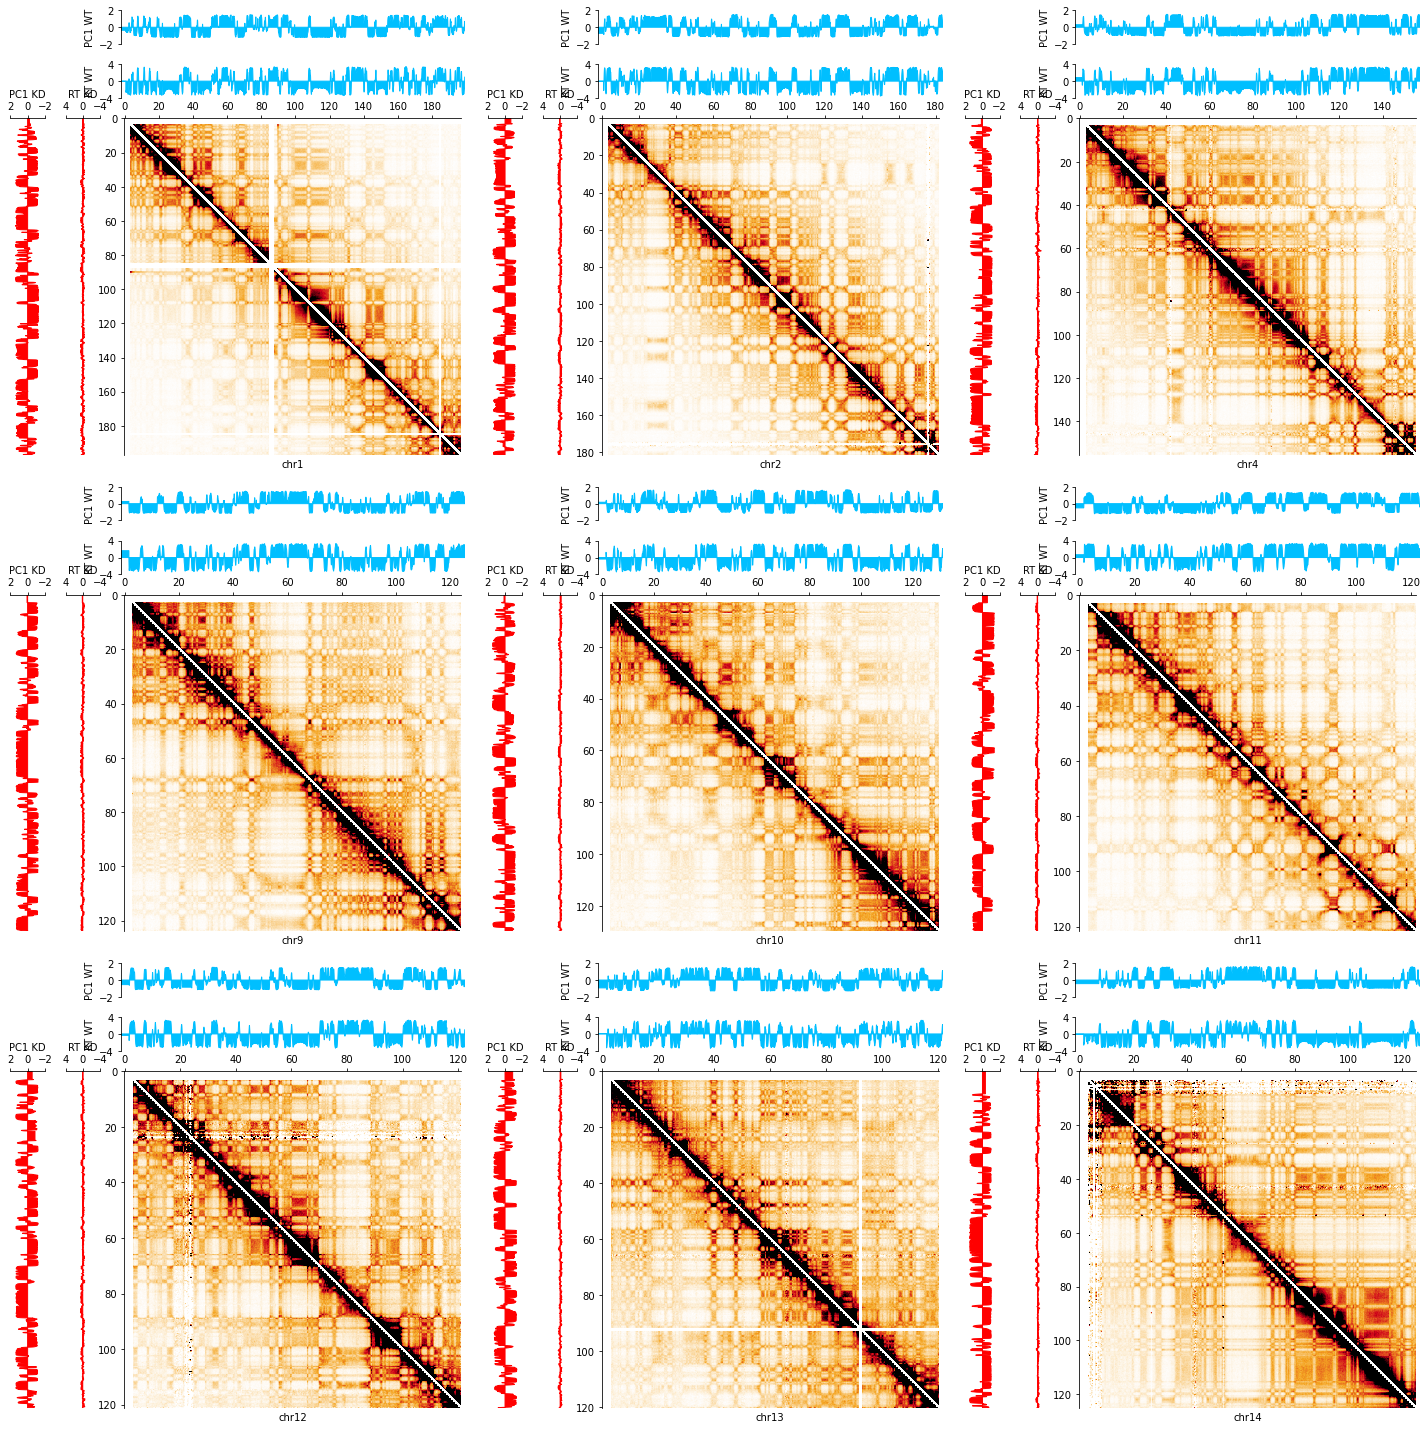

In [118]:
compsignalWT = '/groups/pavri/bioinfo/mihaela/HiC/analysis/ditag/CH12_HiC_shLacZ/CH12_HiC_shLacZ_20kb_w200000.PC1.bw'
compsignalKD = '/groups/pavri/bioinfo/mihaela/HiC/analysis/ditag/CH12_HiC_shMcm/CH12_HiC_shMcm_20kb_w200000.PC1.bw'
RTWT = '/groups/pavri/bioinfo/mihaela/RepliSeq/repliseq-nf/results/bigwigs/unnormalized_loess/shLacZ.loess.bw'
RTKD = '/groups/pavri/bioinfo/mihaela/RepliSeq/repliseq-nf/results/bigwigs/unnormalized_loess/shMcm.loess.bw'
hicWT = 'matrices/CH12_HiC_shLacZ.mcool::resolutions/250000'
hicKD = 'matrices/CH12_HiC_shMcm.mcool::resolutions/250000'

vmin = 0
vmax = 0.0025
fig = plt.figure()
figaxs = generate_subplot_specs(fig, 3, 3)
chromsizes = [('chr1', 197195432),
              ('chr2', 181748087),
              ('chr4', 155630120),
              ('chr9', 124076172),
              ('chr10', 129993255),
              ('chr11', 121843856),
              ('chr12', 121257530),
              ('chr13', 120284312),
              ('chr14', 125194864)]

for axs, (chrom, size) in zip(figaxs, chromsizes):
    matax = plot_whole_chrom_contact_matrix(hicWT, chrom, size, 'weight', cmap, axs[-1], vmin, vmax, extent = 'upper')
    matax = plot_whole_chrom_contact_matrix(hicKD, chrom, size, 'weight', cmap, axs[-1], vmin, vmax, extent = 'lower')
    wtcompax = plot_whole_chrom_bigwig_fill(compsignalWT, chrom, size, 20000, axs[0], blue, blue, matax.get_xlim(), (-2, 2), show_ticks = False, ylabel = 'PC1 WT')
    wtrtax = plot_whole_chrom_bigwig_fill(RTWT, chrom, size, 5000, axs[1], blue, blue, matax.get_xlim(), (-4, 4), show_ticks = False, ylabel = 'RT WT')
    #wtrtax = plot_whole_chrom_bigwig_line(RTWT, chrom, size, 5000, axs[1], blue, matax.get_xlim(), (-4, 4), show_ticks = False, mark_zero = False)
    kdcompax = plot_whole_chrom_bigwig_fill(compsignalKD, chrom, size, 20000, axs[2], 'red', 'red', (-2, 2), matax.get_xlim(), tick_axes = 'y', show_ticks = False, ylabel = 'PC1 KD')
    kdrtax = plot_whole_chrom_bigwig_fill(RTKD, chrom, size, 5000, axs[3], 'red', 'red', (-4, 4), matax.get_xlim(), tick_axes = 'y', show_ticks = False, ylabel = 'RT KD')
    #kdrtax = plot_whole_chrom_bigwig_line(RTKD, chrom, size, 5000, axs[3], 'red', (-4, 4), matax.get_xlim(), tick_axes = 'y', show_ticks = False, mark_zero = False)
    matax.set_xlabel(chrom)
    
    
fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout()
fig.savefig('plots/whole_chrom_examples.pdf')